Create a dataset that can be visualized and therefore better understood using the preprocessing techniques I've learned 

In [41]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [42]:
FILENAME = 'NBADATA.csv'

In [43]:
data = pd.read_csv(FILENAME) 
data['3P%'] = np.divide(data['3P'].values,data['3PA'].values) 
del data['3P'],data['3PA']
data['FG%'] = np.divide(data['FG'].values,data['FGA'].values)
del data['FG'],data['FGA']
data['FT%'] = np.divide(data['FT'].values,data['FTA'].values)
del data['Unnamed: 0'],data['PLUS_MINUS'],data['TOTAL']
del data['FT'],data['FTA']
del data['OU']
#del data['Team']
#data = pd.get_dummies(data)

In [44]:
teams = data.Team.unique()

In [45]:
NBA_DATA_USING_SPLITS = pd.DataFrame([])
nba_data = pd.DataFrame([])
for team in teams:
    team_data = data.loc[data['Team'] == team]  #this contains the box score of every team game from 2013 to 2018. 
    stuff_to_turn_into_avgs = ['OR', 'DR', 'TOT', 'PF', 'ST', 'TO', 'BL', '3P%', 'FG%', 'FT%']
    for col in team_data.columns:
        if col in stuff_to_turn_into_avgs:
            team_data['Rolling ' + col] = team_data[col].rolling(window=5).mean().shift(1)
            del team_data[col]
                    #retrieves the game
                
    nba_data =  nba_data.append(team_data)
           # df = pd.concat([road_df,home_df],axis=1)



/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
nba_data_splits = nba_data.sort_values(by = ['GAME_ID', 'Home'], ascending=[True, True])

In [47]:
nba_data_splits.dropna(inplace=True)

In [48]:
del nba_data_splits['GAME_ID'],nba_data_splits['Team'],nba_data_splits['Home'],nba_data_splits['Away'],nba_data_splits['Date']


In [49]:
road_df = nba_data_splits.iloc[::2]
home_df = nba_data_splits.iloc[1::2]
for col in nba_data_splits.columns:
    road_df['road_' + col] = road_df[col]
    home_df['home_' + col] = home_df[col]
    
    del road_df[col],home_df[col]

home_df.reset_index(inplace=True)
road_df.reset_index(inplace=True)

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
df = pd.concat([road_df,home_df],axis=1)
del df['index']

In [51]:
#roadpts = df['road_PTS']       #column of all the points scored by road team 
#homepts = df['home_PTS']
#endspreadS = roadpts-homepts  #all the final spreads of the game
spread = True
winner = False

df['final_SPREAD'] = df['road_PTS'] - df['home_PTS']
del df['road_PTS'], df['home_PTS'],df['home_SPREAD']
           # if openspread + endspread <0:
            #    y.append(np.array([0,1,0]))  #home team covered
            #elif openspread + endspread >0:
            #    y.append(np.array([1,0,0]))  #road covered
           # else: 
           #     y.append(np.array([0,0,1]))  #push!
y = []

if spread: 
    for i in range(len(df)):
        if df['road_SPREAD'].values[i] + df['final_SPREAD'].values[i] < 0:
            y.append(1) #home team covers
        else: # df['road_SPREAD'].values[i] + df['final_SPREAD'].values[i] > 0:
            y.append(0) #road team covers or push
    #else:
    #    y.append(np.array([0,1]))  #push! 
    
if winner:
    for i in range(len(df)):
        if df['final_SPREAD'].values[i] < 0: #home team won. 
            y.append(1)
        else:
            y.append(0)

del df['final_SPREAD']


In [52]:
y_names = np.array(['road team', 'home team'])

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(df.values,y,random_state = 42)

In [54]:
print(X_train.shape)


(4850, 21)


In [55]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [57]:
X_pca = pca.transform(X_train)


In [58]:
len(X_pca[:,1])

4850

In [59]:
len(X_pca[:,0])

4850

In [60]:
len(y)

6467

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

import mglearn

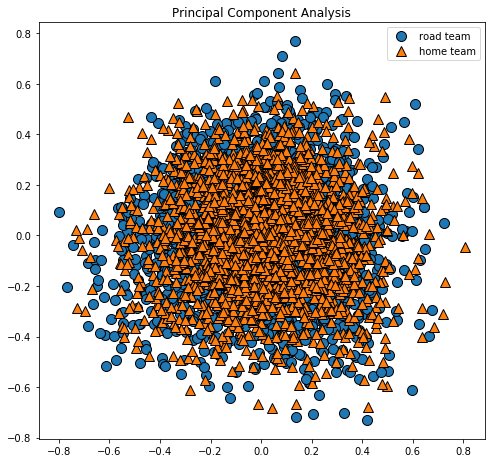

In [62]:
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:,0],X_pca[:,1],y_train)
plt.legend(y_names,loc='best')
plt.gca().set_aspect('equal')
plt.title('Principal Component Analysis')

There is a little bit of separation, meaning there is something to exploit! By examining the features below, we can see which play the biggest role, and could be responsible for this...

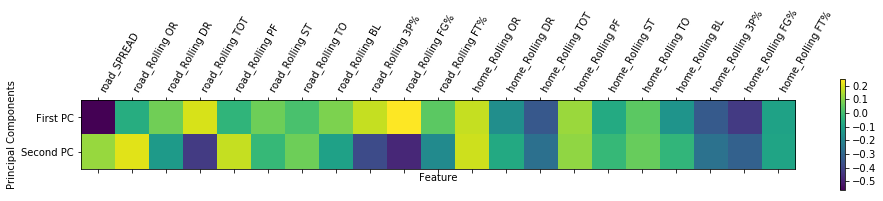

In [63]:
plt.figure()
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1],['First PC','Second PC'])
plt.colorbar()
plt.xticks(range(len(np.array(df.columns))),np.array(df.columns),rotation=60,ha='left')
plt.xlabel('Feature')
plt.ylabel('Principal Components')

Based on this it appears the first PC is mainly rooted in the field goal %, given the home fg% is the most important, followed by spread it seems. 

In [64]:
from sklearn.neural_network import MLPClassifier

In [65]:
clf = MLPClassifier()

In [66]:
clf.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [67]:
clf.score(X_train,y_train)

0.5292783505154639

In [68]:
clf.score(X_test,y_test)

0.4904143475572047

In [ ]:
np.array(df.columns)

In [ ]:
cancer = load_breast_cancer()

In [ ]:
cancer.feature_names

In [ ]:
y_names = np.array(['road team', 'home team'])

In [ ]:
y_names